# Datenanlyse zur Umfrage Persönliche Expertise

---

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns



## Import data from csv

In [2]:
filename = 'data/export_0907.csv'
df = pd.read_csv(filename, sep=';')

In [3]:
df.head()

,lfdn,external_lfdn,tester,dispcode,lastpage,quality,duration,c_0001,c_0002,c_0003,...,rnd_pg_7356560_3,rnd_pg_7356560_4,rnd_pg_7356560_5,rnd_pg_7356560_6,rnd_pg_7356570_1,rnd_pg_7356570_2,rnd_pg_7356570_3,rnd_pg_7356570_4,rnd_pg_7356570_5,rnd_pg_7356570_6
0,176,0,0,31,7356546,-77,783,3,-66,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
1,178,0,0,31,7356546,-77,1691,2,-66,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
2,181,0,0,31,7356546,-77,865,-66,1,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
3,182,0,0,31,7356546,-77,536,-66,2,-66,...,7356565,7356566,7356563,7356561,-77,-77,-77,-77,-77,-77
4,184,0,0,31,7356546,-77,680,1,-66,970,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77


In [4]:
df['priming'] = df['c_0001'].replace(-66, np.nan).fillna(df['c_0002']).astype(int)


In [5]:
def classify_professional(row):
    # Check if any CVPA score is less than 2
    cvpa_columns = ['v_8978', 'v_9154', 'v_9155', 'v_9156', 'v_9157', 'v_9158', 'v_9159', 'v_9160', 'v_9308']
    for col in cvpa_columns:
        if row[col] < 2:
            return False
    
    # Check if sum of CVPA scores is less than 34
    cvpa_sum = sum(row[col] for col in cvpa_columns)
    if cvpa_sum < 34:
        return False
    
    # Count correct answers for knowledge questions
    correct_answers = 0
    knowledge_answers = {
        'v_206': 3,
        'v_207': 3,
        'v_208': 2,
        'v_209': 2,
        'v_210': 3,
        'v_211': 3,
        'v_212': 2,
        'v_213': 4,
        'v_214': 1,
        'v_215': 3
    }
    
    for col, correct_value in knowledge_answers.items():
        if col in row and row[col] == correct_value:
            correct_answers += 1
    
    # Check if correct answers is less than 6
    if correct_answers < 6:
        return False
    
    return True

# Apply the classification function to create a new column
df['is_professional'] = df.apply(classify_professional, axis=1)

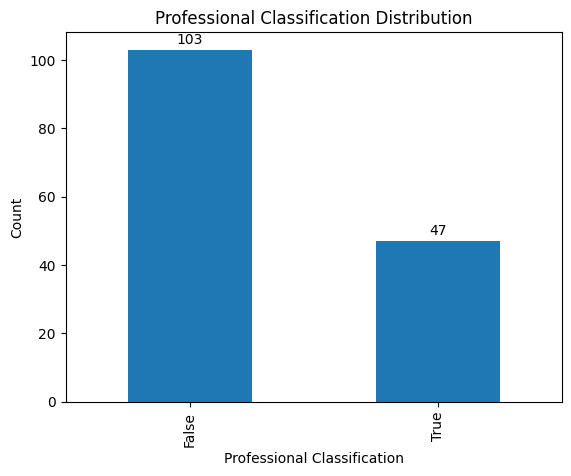

In [6]:
counts = df['is_professional'].value_counts()
ax = counts.plot(kind='bar', title='Professional Classification Distribution')
ax.set_xlabel('Professional Classification')
ax.set_ylabel('Count')

# Add value labels on top of bars
for i, v in enumerate(counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

## Forschungsfrage
- Hat die persönliche Expertise von
Konsument:innen einen Einfluss auf
Präferenzen und Preiserwartungen von
stilistisch konsistenten und
inkonsistenten Produktensembles.

## Hypothesen

### Hypothesen zu Präferenzen:
**H0₁:** Persönliche Expertise hat **keinen** Einfluss auf die Präferenzen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten = μ_Nicht-Experten (bezüglich Präferenzwerten)

**H1₁:** Persönliche Expertise hat einen **signifikanten** Einfluss auf die Präferenzen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten ≠ μ_Nicht-Experten (bezüglich Präferenzwerten)

### Hypothesen zu Preiserwartungen:
**H0₂:** Persönliche Expertise hat **keinen** Einfluss auf die Preiserwartungen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten = μ_Nicht-Experten (bezüglich Preiserwartungen)

**H1₂:** Persönliche Expertise hat einen **signifikanten** Einfluss auf die Preiserwartungen für stilistisch konsistente vs. inkonsistente Produktensembles.
- μ_Experten ≠ μ_Nicht-Experten (bezüglich Preiserwartungen)

### Statistische Tests:
- **Unabhängige t-Tests** für Mittelwertvergleiche zwischen Experten (`is_professional = True`) und Nicht-Experten (`is_professional = False`)
- **Signifikanzniveau:** α = 0.05
- **Zweiseitige Tests** (da keine gerichtete Hypothese vorliegt)

## Variablen
### Abhängige Variablen (AV)

- **Preiserwartung**  
  Für welchen Preis würden Sie erwarten, dass das Produkt/Ensemble angeboten wird? (metrisch)  
  - einzeln  
  - ensemble  
  - korrektur ensemble

- **Objektive Einzelbewertung (Liking)**  
  - minderwertig ↔ hochwertig (Likert-Skala)  
  - einfach ↔ luxuriös (Likert-Skala)  
  - billig ↔ teuer (Likert-Skala)

- **Subjektive Einzelbewertung (Liking)**  
  - Das Produkt gefällt mir gut. (Likert-Skala)  
  - Ich mag das Produkt. (Likert-Skala)  
  - Ich finde das Produkt ansprechend. (Likert-Skala)

- **Objektive Ensemble-Bewertung**  
  - minderwertig ↔ hochwertig (Likert-Skala)  
  - einfach ↔ luxuriös (Likert-Skala)  
  - billig ↔ teuer (Likert-Skala)

- **Subjektive Ensemble-Bewertung**  
  - Das Ensemble gefällt mir gut. (Likert-Skala)  
  - Ich mag das Ensemble. (Likert-Skala)  
  - Ich finde das Ensemble ansprechend. (Likert-Skala)

- **Produktdarstellung**  
  - Die Kombination vermittelt mir relevante Informationen über die Produkte. (Likert-Skala)  
  - Die gezeigte Zusammenstellung hilft mir, die Produkte besser zu verstehen. (Likert-Skala)  
  - Die Präsentation erleichtert es mir, die Produkte zu beurteilen. (Likert-Skala)  
  - Durch die Präsentation kann ich mir vorstellen, welche Personen dieses Outfit tragen würden. (Likert-Skala)  
  - Durch die Präsentation kann ich mir vorstellen, in welchen beruflichen Situationen das Outfit getragen wird. (Likert-Skala)  
  - Ich verstehe, wie man die Teile elegant, seriös und professionell kombiniert. (Likert-Skala)

- **Bewertungsleichtigkeit**  
  - Es fällt mir leicht, das Outfit zu bewerten. (Likert-Skala)  
  - Ich erfasse das Outfit visuell schnell. (Likert-Skala)  
  - Ich kann mir das Outfit mit geschlossenen Augen in Erinnerung rufen. (Likert-Skala)  
  - Ich kann das Outfit später einer anderen Person beschreiben. (Likert-Skala)

- **Gesamtwirkung**  
  - uneinheitlich ↔ einheitlich (Likert-Skala)  
  - unstimmig ↔ stimmig (Likert-Skala)  
  - unharmonisch ↔ harmonisch (Likert-Skala)

- **Stileinordnung**  
  - Hippie (Likert-Skala)  
  - Hip Hop / Active Wear (Likert-Skala)  
  - Boho (Likert-Skala)

---

### Unabhängige Variablen (UV)


- **Priming-Konsistenz**  
  - konsistentes Ensemble  
  - inkonsistentes Ensemble  
  - inkonsistentes Ensemble mit nichtansprechendem Oberteil

- **Stilrichtung**  
  - Hippie × Minimalistisch

- **Produktkategorie**  
  - Oberteil

- **Expertenstatus**  
  - Experte vs. Nicht-Experte (gemäß Faktenwissen & CVPA)

> **Design:** 3 × 2-Faktor (Priming-Konsistenz × Expertenstatus), between-subjects

---

### Kontroll- und Störvariablen

- **Demografische Variablen**  
  - Alter (metrisch, Jahre)  
  - Geschlecht (nominal, z. B. m/w/d)  
  - Einkommen (metrisch oder ordinal gruppiert)  
  - Bildungsgrad (ordinal)  
  - Beruf (nominal)

- **Berufserfahrung**  
  - (metrisch, Jahre)

- **CVPA-Score**  
  - (metrisch)

- **Faktenwissen-Score**  
  - (metrisch)


## Überprüfung der Hypothesen

---

### Hypothese 1 (Präferenzwerte)
- **Hypothese:**  
  - H₀₁: μ$_{Experten}$ = μ$_{NOT-Experten}$
  - H₁₁: μ$_{Experten}$ ≠ μ$_{NOT-Experten}$
- **Variable:**  
  - Liking - Mittelwert
- **Methode:**  
  - **Unabhängiger t-Test** (zweiseitig)  
    - *Warum:* Vergleich von Mittelwerten zweier unabhängiger Gruppen bei intervallskaliertem DV  
- **Voraussetzungen prüfen:**  
  - **Normalverteilung** der Liking in beiden Gruppen (Shapiro-Wilk-Test)
  - **Varianzhomogenität** (Levene-Test)  
- **Alternative bei Verletzung:**  
  - **Mann-Whitney-U-Test** (zweiseitig)  
    - *Warum:* Kein parametrischer Test, robust gegen Normalitätsverletzung  
- **Effektstärke:**  
  - Cohen’s d (t-Test) oder Rang-Biseriale Korrelation (Mann-Whitney)

---

### Hypothese 2 (Preiserwartungen)
- **Hypothese:**  
  - H₀₂: μ$_{Experten}$ = μ$_{NOT-Experten}$
  - H₁₂: μ$_{Experten}$ ≠ μ$_{NOT-Experten}$
- **Variable:**  
  - Preiserwartung
- **Statistisches Mittel & Vorgehen:**  
  - Analog zu Hypothese 1 (t-Test, Voraussetzungen, Alternative, Effektstärke)

---

### Hypothese 3 (Wertigkeit)
- **Hypothese:**  
  - H₀₂: μ$_{Experten}$ = μ$_{NOT-Experten}$
  - H₁₂: μ$_{Experten}$ ≠ μ$_{NOT-Experten}$
- **Variable:**  
  - Wertigkeit
- **Statistisches Mittel & Vorgehen:**  
  - Analog zu Hypothese 1 (t-Test, Voraussetzungen, Alternative, Effektstärke)

---

### Signifikanz & Bericht
- **α = 0,05** (zweiseitig)  
- **Bericht:**  
  - Teststatistik (t-Wert bzw. U-Wert), p-Wert, Effektstärke  
  - Überprüfung der Testvoraussetzungen dokumentieren  


### Data cleaning

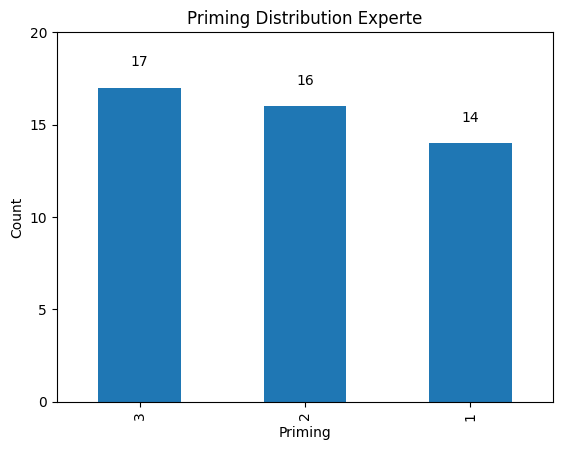

In [7]:
# Distribution of priming levels
filtered_rows = df[df['is_professional']].copy()
priming_counts = filtered_rows['priming'].value_counts()
ax = priming_counts.plot(kind='bar', title='Priming Distribution Experte')
ax.set_xlabel('Priming')
ax.set_ylabel('Count')
ax.set_yticks(range(0, priming_counts.max() + 5, 5))

# Add value labels on top of bars
for i, v in enumerate(priming_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

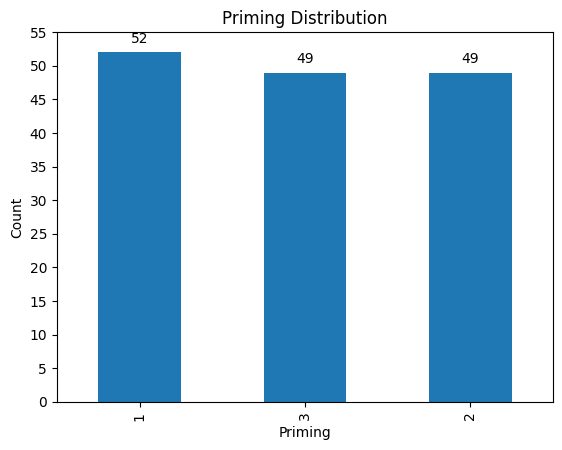

In [8]:
# Alternative priming distribution (column c_0002 replaced)
# Using combined 'priming' column instead
priming_counts = df['priming'].value_counts()
ax = priming_counts.plot(kind='bar', title='Priming Distribution')
ax.set_xlabel('Priming')
ax.set_ylabel('Count')
ax.set_yticks(range(0, priming_counts.max() + 5, 5))

# Add value labels on top of bars
for i, v in enumerate(priming_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

In [9]:
rename_map = dict()
inverse_map = dict()
def reduce_columns(row):
    # Get all columns that start with 'v_'
    v_columns = [col for col in row.index if col.startswith('v_')]

    # Filter out columns that have negative values
    valid_columns = ['priming', 'is_professional']  # Always include these columns
    counter = 0
    for col in v_columns:
        try:
            if int(row[col]) >= 0:
                valid_columns.append(col)
                counter += 1
                if f"Q{counter}" not in rename_map:
                    rename_map[f"Q{counter}"] = col
                else:
                    rename_map[f"Q{counter}"] += col
                
                if col not in inverse_map:
                    inverse_map[col] = f"Q{counter}"
                else:
                    inverse_map[col] = f"Q{counter}"
        except ValueError:
            # If conversion to int fails, skip this column
            continue
    
    # Create the result series with renamed columns
    result = {}
    for col in valid_columns:
        if col in inverse_map:
            # Use the Q-column name from inverse_map
            result[inverse_map[col]] = row[col]
        else:
            # Keep original column name for non-v columns
            result[col] = row[col]
    
    return pd.Series(result)
    


combined_df = df.apply(reduce_columns, axis=1)
combined_df.head()

,priming,is_professional,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q90,Q91,Q92,Q93,Q94,Q95,Q96,Q97,Q98,Q99
0,3,True,2,0,0,0,0,0,0,0,...,5,4,3,4,3,2,51,1,2,4
1,2,True,1,1,1,0,1,0,0,0,...,5,5,4,5,1,1,47,1,2,4
2,1,False,2,0,0,0,0,0,0,0,...,5,5,4,4,2,2,60,2,2,5
3,2,False,2,0,0,0,0,0,0,0,...,5,5,5,4,1,1,22,1,1,1
4,1,True,2,0,0,0,1,0,0,0,...,4,5,4,4,1,3,19,1,1,3


In [10]:
def get_q_columns_from_v(v_cols, rename_map):
    """
    Given a list of original 'v_' column names and the list of rename_maps,
    return a set of corresponding new 'Q' column names across all subsets.
    """
    q_cols_set = set()
    for v in v_cols:
        if v in rename_map:
            q_cols_set.add(rename_map[v])
    return q_cols_set

# Example usage:
q_set = get_q_columns_from_v(['v_10915'], inverse_map)
print(q_set)

{'Q42'}


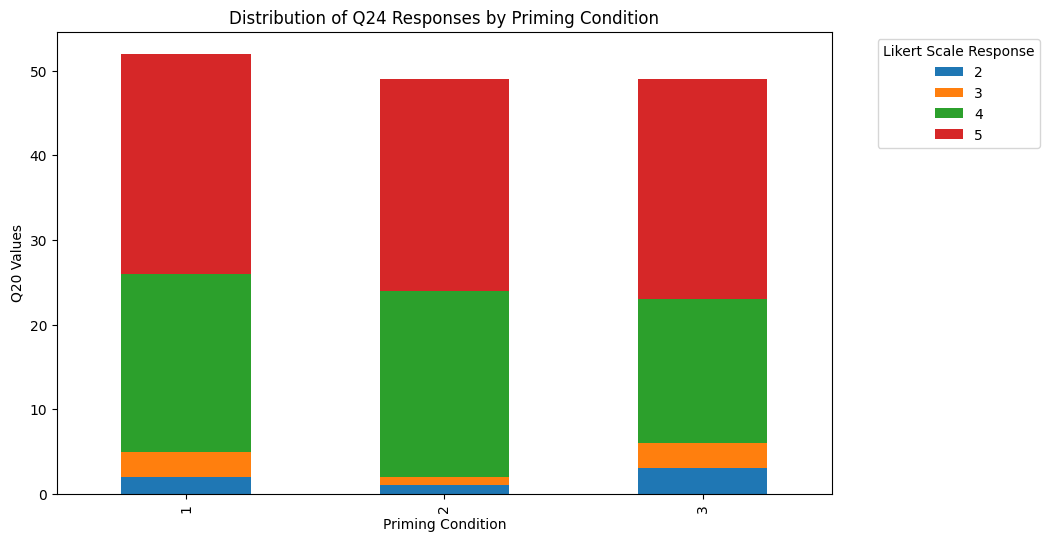

In [11]:
# Create a stacked bar chart showing distribution of responses
response_counts = combined_df.groupby(['priming', 'Q24']).size().unstack(fill_value=0)
ax = response_counts.plot(kind='bar', stacked=True, figsize=(10, 6), 
                         title='Distribution of Q24 Responses by Priming Condition')
ax.legend(title='Likert Scale Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('')  
plt.xlabel('Priming Condition')
plt.ylabel('Q20 Values')
plt.show()

/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_76155/2094796301.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['mean_columns'] = combined_df[columns_to_analyze].mean(axis=1)


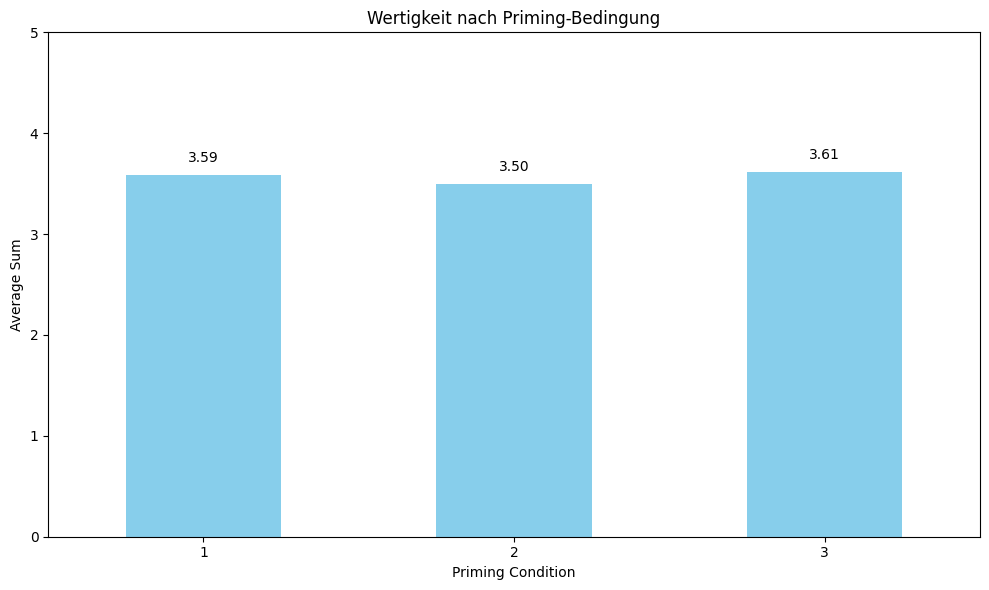

In [12]:
q_set = get_q_columns_from_v(['v_10903','v_10904','v_10905'], inverse_map)
# q_set = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']  # Example Q columns to analyze

columns_to_analyze = list(q_set)

# Calculate mean of the columns for each row, then average by priming condition
if columns_to_analyze:
    combined_df['mean_columns'] = combined_df[columns_to_analyze].mean(axis=1)
    mean_by_priming = combined_df.groupby(['priming'])['mean_columns'].mean()
    
    # Create bar chart using matplotlib
    fig, ax = plt.subplots(figsize=(10, 6))
    mean_by_priming.plot(kind='bar', ax=ax, title='Wertigkeit nach Priming-Bedingung', color='skyblue')
    ax.set_xlabel('Priming Condition')
    ax.set_ylabel('Average Sum')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticks(range(0, 6, 1))
    
    # Add value labels on top of bars
    for i, v in enumerate(mean_by_priming.values):
        ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("No columns available for analysis")

<Figure size 1000x600 with 0 Axes>

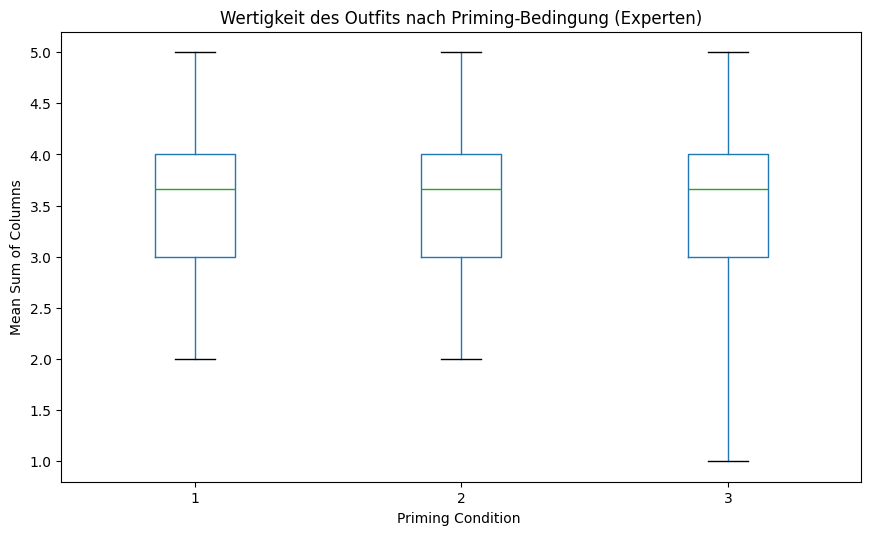

In [13]:
# Boxplot of mean_columns distribution by priming condition
plt.figure(figsize=(10, 6))
# Use pandas boxplot grouped by c_0001, whiskers to min/max to include all points
combined_df.boxplot(column='mean_columns', by='priming', grid=False, figsize=(10, 6), whis=[0,100])
plt.title('Wertigkeit des Outfits nach Priming-Bedingung (Experten)')
plt.xlabel('Priming Condition ')
plt.ylabel('Mean Sum of Columns')
plt.suptitle('')  # clear the automatic suptitle
plt.show()

### Hypothese 1

In [14]:
liking_columns = ['v_10959','v_10960','v_10961', 'v_10906','v_10907','v_10908','v_10915','v_10916','v_10917', 'v_10924','v_10925','v_10926', 'v_10933','v_10934','v_10935', 'v_10942','v_10943','v_10944', 'v_10951','v_10952','v_10953']

In [15]:
q_set = get_q_columns_from_v(liking_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['mean_liking'] = combined_df[columns_to_analyze].mean(axis=1)

for prim in combined_df['priming'].unique():
    for prof in [True, False]:
        grp = combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_liking']
        if len(grp) >= 3:
            W, p = shapiro(grp)
            print(f"Shapiro prim={prim}, prof={prof}: W={W:.3f}, p={p:.4f}")

Shapiro prim=3, prof=True: W=0.920, p=0.1477
Shapiro prim=3, prof=False: W=0.962, p=0.3084
Shapiro prim=2, prof=True: W=0.912, p=0.1254
Shapiro prim=2, prof=False: W=0.928, p=0.0298
Shapiro prim=1, prof=True: W=0.942, p=0.4380
Shapiro prim=1, prof=False: W=0.974, p=0.5185


/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_76155/43044611.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['mean_liking'] = combined_df[columns_to_analyze].mean(axis=1)


In [16]:
groups = [
    combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_liking']
    for prim in combined_df['priming'].unique() 
    for prof in [True, False]
]
W_le, p_le = levene(*groups)
print(f"\nLevene-Test: W={W_le:.3f}, p={p_le:.4f}")


Levene-Test: W=0.885, p=0.4927


In [17]:
model = ols('mean_liking ~ C(priming) * C(is_professional)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA-Tabelle (Typ II):")
print(anova_table)


ANOVA-Tabelle (Typ II):
                                  sum_sq     df         F    PR(>F)
C(priming)                      1.112365    2.0  1.006551  0.368034
C(is_professional)              4.018654    1.0  7.272758  0.007836
C(priming):C(is_professional)   0.180883    2.0  0.163677  0.849174
Residual                       79.569023  144.0       NaN       NaN


In [18]:
def summarize_anova(anova_df, alpha=0.05):
    """
    Druckt eine übersichtliche Zusammenfassung der ANOVA-Ergebnisse inklusive
    Effektstärken (η²) und kurzer Interpretation.
    
    Parameter:
    - anova_df: pandas DataFrame mit Spalten ['sum_sq', 'df', 'F', 'PR(>F)']
                und Index = Effektnamen (z.B. 'Priming', 'Professionalität', 'Residual').
    - alpha:    Signifikanzniveau (Standard: 0.05).
    """
    # Effektstärke η² berechnen
    anova_df = anova_df.copy()
    anova_df['eta_sq'] = anova_df['sum_sq'] / anova_df['sum_sq'].sum()
    
    # Schwellwerte nach Cohen (Faustwerte)
    def effect_size_label(eta):
        if eta < 0.01:
            return "vernachlässigbar"
        elif eta < 0.06:
            return "klein"
        elif eta < 0.14:
            return "mittel"
        else:
            return "groß"
    
    # Ausgabe
    for name, row in anova_df.iterrows():
        if name.lower() == 'residual':
            continue  # Residual nicht interpretieren
        F = row['F']
        p = row['PR(>F)']
        eta = row['eta_sq']
        signif = "signifikant" if p < alpha else "nicht signifikant"
        size_label = effect_size_label(eta)
        
        print(f"Effekt '{name}': F({int(row['df'])}) = {F:.2f}, p = {p:.3f}, η² = {eta:.3f} ({size_label}), {signif}.")
    print(f"(α = {alpha})")

In [19]:
summarize_anova(anova_table)

Effekt 'C(priming)': F(2) = 1.01, p = 0.368, η² = 0.013 (klein), nicht signifikant.
Effekt 'C(is_professional)': F(1) = 7.27, p = 0.008, η² = 0.047 (klein), signifikant.
Effekt 'C(priming):C(is_professional)': F(2) = 0.16, p = 0.849, η² = 0.002 (vernachlässigbar), nicht signifikant.
(α = 0.05)


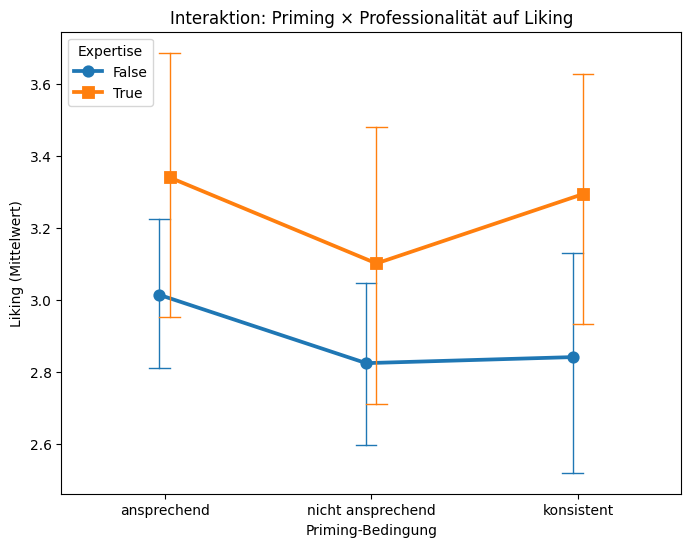

In [20]:
plt.figure(figsize=(8,6))
sns.pointplot(
    data=combined_df, x='priming', y='mean_liking', hue='is_professional',
    dodge=True, markers=['o','s'], capsize=.1, err_kws={'linewidth': 1}
)
plt.title('Interaktion: Priming × Professionalität auf Liking')
plt.xlabel('Priming-Bedingung')
# plt.yticks(range(0, 6, 1))
plt.xticks([0,1,2], ['ansprechend', 'nicht ansprechend', 'konsistent'])

plt.ylabel('Liking (Mittelwert)')
plt.legend(title='Expertise')
plt.show()

### Hypothese 2

In [ ]:
price_columns = ['v_11376']
q_set = get_q_columns_from_v(price_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['outfit_sum'] = combined_df[columns_to_analyze]


,Q73
count,150.000000
mean,1101.800000
std,929.756806
min,190.000000
25%,522.750000
50%,802.500000
75%,1251.250000
max,6000.000000


In [35]:
price_columns = ['v_10902', 'v_10911', 'v_10920', 'v_10929', 'v_10938', 'v_10947' ]
q_set = get_q_columns_from_v(price_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['outfit_sum'] = combined_df[columns_to_analyze].sum(axis=1)


/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_76155/676525762.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['outfit_sum'] = combined_df[columns_to_analyze].sum(axis=1)


In [36]:
for prim in combined_df['priming'].unique():
    for prof in [True, False]:
        grp = combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['outfit_sum']
        if len(grp) >= 3:
            W, p = shapiro(grp)
            print(f"Shapiro prim={prim}, prof={prof}: W={W:.3f}, p={p:.4f}")

Shapiro prim=3, prof=True: W=0.878, p=0.0291
Shapiro prim=3, prof=False: W=0.496, p=0.0000
Shapiro prim=2, prof=True: W=0.874, p=0.0311
Shapiro prim=2, prof=False: W=0.849, p=0.0003
Shapiro prim=1, prof=True: W=0.751, p=0.0013
Shapiro prim=1, prof=False: W=0.803, p=0.0000


In [37]:
groups = [
    combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['outfit_sum']
    for prim in combined_df['priming'].unique() 
    for prof in [True, False]
]
W_le, p_le = levene(*groups)
print(f"\nLevene-Test: W={W_le:.3f}, p={p_le:.4f}")


Levene-Test: W=1.078, p=0.3751


In [38]:
model = ols('outfit_sum ~ C(priming) * C(is_professional)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA-Tabelle (Typ II):")
print(anova_table)


ANOVA-Tabelle (Typ II):
                                     sum_sq     df         F    PR(>F)
C(priming)                     5.215139e+05    2.0  0.264244  0.768158
C(is_professional)             6.196071e+06    1.0  6.278927  0.013331
C(priming):C(is_professional)  1.443921e+06    2.0  0.731615  0.482911
Residual                       1.420998e+08  144.0       NaN       NaN


In [39]:
summarize_anova(anova_table)

Effekt 'C(priming)': F(2) = 0.26, p = 0.768, η² = 0.003 (vernachlässigbar), nicht signifikant.
Effekt 'C(is_professional)': F(1) = 6.28, p = 0.013, η² = 0.041 (klein), signifikant.
Effekt 'C(priming):C(is_professional)': F(2) = 0.73, p = 0.483, η² = 0.010 (vernachlässigbar), nicht signifikant.
(α = 0.05)


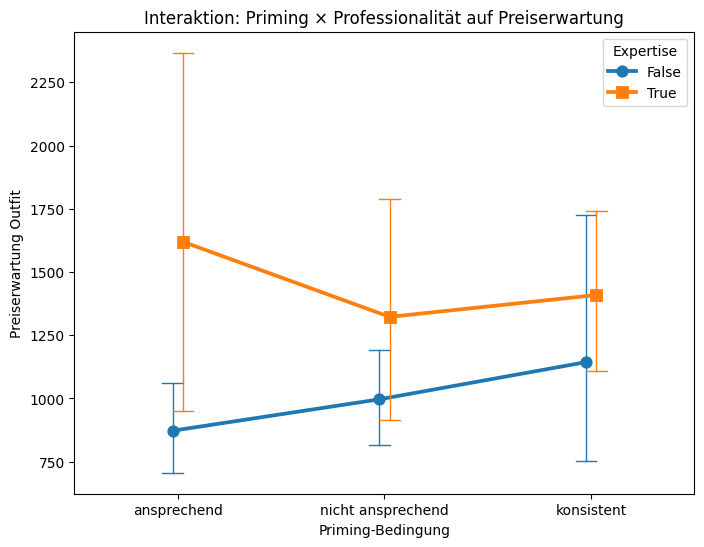

In [40]:
plt.figure(figsize=(8,6))
sns.pointplot(
    data=combined_df, x='priming', y='outfit_sum', hue='is_professional',
    dodge=True, markers=['o','s'], capsize=.1, err_kws={'linewidth': 1}
)
plt.title('Interaktion: Priming × Professionalität auf Preiserwartung')
plt.xlabel('Priming-Bedingung')
# plt.yticks(range(0, 6, 1))
plt.ylabel('Preiserwartung Outfit')
plt.xticks([0,1,2], ['ansprechend', 'nicht ansprechend', 'konsistent'])
plt.legend(title='Expertise')
plt.show()

### Hypothese 3

In [41]:
quality_columns = ['v_10903','v_10904','v_10905','v_10912','v_10913','v_10914', 'v_10921','v_10922','v_10923', 'v_10930','v_10931','v_10932', 'v_10939','v_10940','v_10941', 'v_10948','v_10949','v_10950', 'v_10956','v_10957','v_10958']
q_set = get_q_columns_from_v(quality_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['mean_quality'] = combined_df[columns_to_analyze].mean(axis=1)

/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_76155/2963009300.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['mean_quality'] = combined_df[columns_to_analyze].mean(axis=1)


In [42]:
for prim in combined_df['priming'].unique():
    for prof in [True, False]:
        grp = combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_quality']
        if len(grp) >= 3:
            W, p = shapiro(grp)
            print(f"Shapiro prim={prim}, prof={prof}: W={W:.3f}, p={p:.4f}")

Shapiro prim=3, prof=True: W=0.911, p=0.1054
Shapiro prim=3, prof=False: W=0.966, p=0.3875
Shapiro prim=2, prof=True: W=0.984, p=0.9867
Shapiro prim=2, prof=False: W=0.983, p=0.8785
Shapiro prim=1, prof=True: W=0.966, p=0.8263
Shapiro prim=1, prof=False: W=0.977, p=0.5969


In [43]:
groups = [
    combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_quality']
    for prim in combined_df['priming'].unique() 
    for prof in [True, False]
]
W_le, p_le = levene(*groups)
print(f"\nLevene-Test: W={W_le:.3f}, p={p_le:.4f}")


Levene-Test: W=1.075, p=0.3765


In [44]:
model = ols('mean_quality ~ C(priming) * C(is_professional)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

summarize_anova(anova_table)

Effekt 'C(priming)': F(2) = 0.77, p = 0.465, η² = 0.011 (klein), nicht signifikant.
Effekt 'C(is_professional)': F(1) = 0.18, p = 0.670, η² = 0.001 (vernachlässigbar), nicht signifikant.
Effekt 'C(priming):C(is_professional)': F(2) = 0.14, p = 0.869, η² = 0.002 (vernachlässigbar), nicht signifikant.
(α = 0.05)


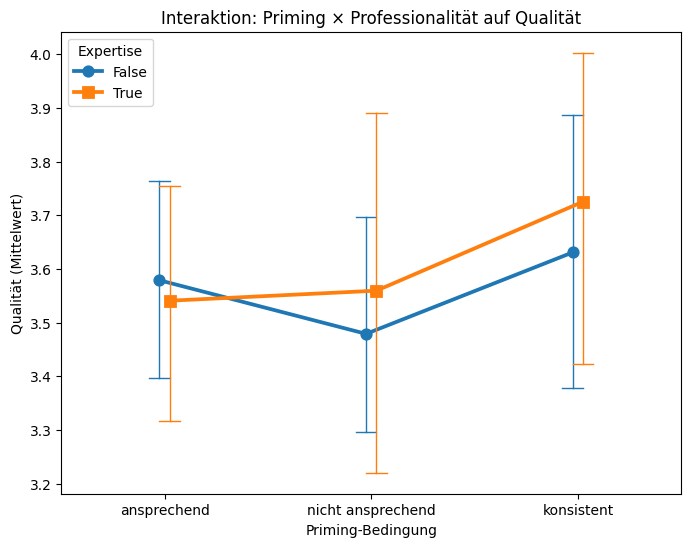

In [45]:
plt.figure(figsize=(8,6))
sns.pointplot(
    data=combined_df, x='priming', y='mean_quality', hue='is_professional',
    dodge=True, markers=['o','s'], capsize=.1, err_kws={'linewidth': 1}
)
plt.title('Interaktion: Priming × Professionalität auf Qualität')
plt.xlabel('Priming-Bedingung')
# plt.yticks(range(0, 6, 1))
plt.xticks([0,1,2], ['ansprechend', 'nicht ansprechend', 'konsistent'])

plt.ylabel('Qualität (Mittelwert)')
plt.legend(title='Expertise')
plt.show()

### Demographische Daten

#### Alter

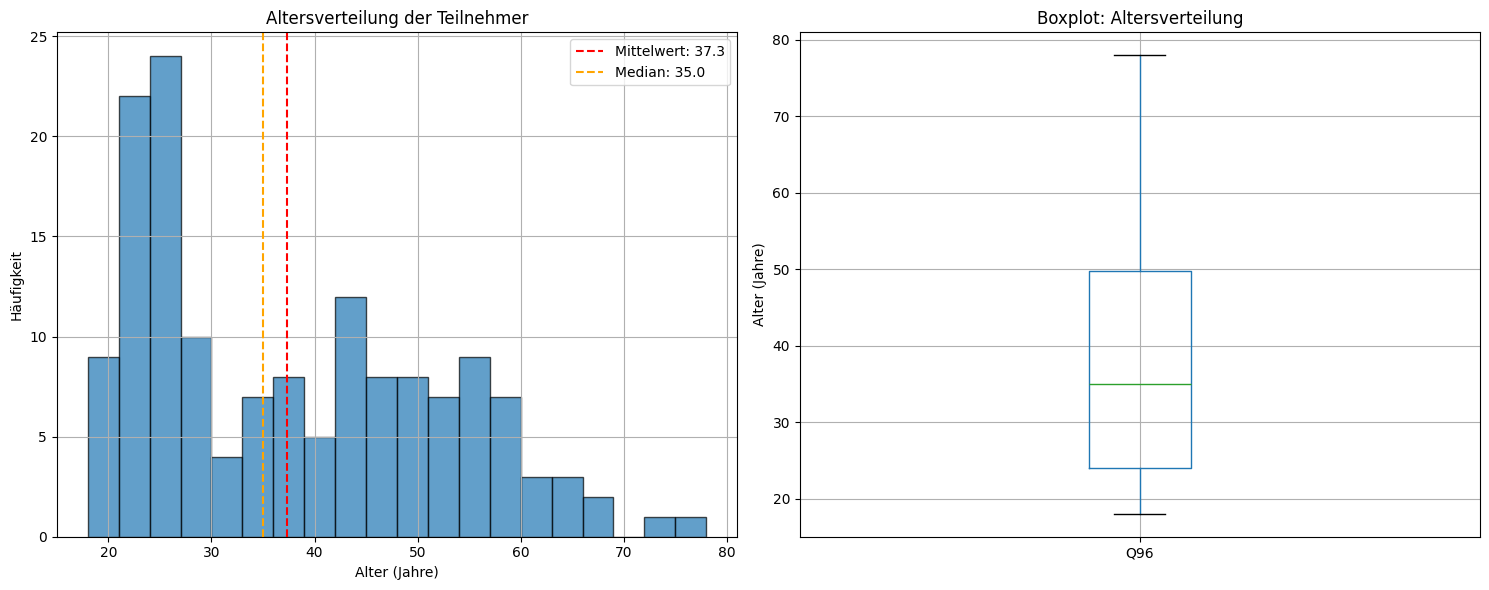

<Figure size 1000x600 with 0 Axes>

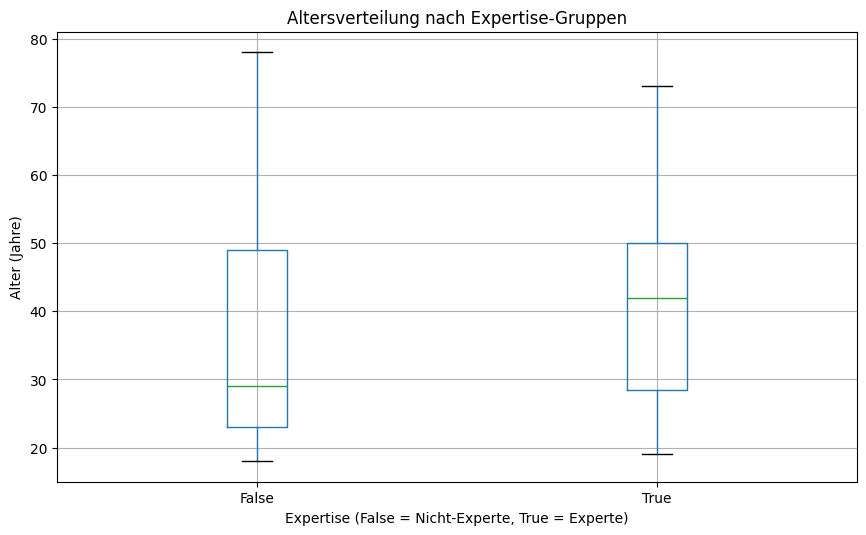

In [27]:
q_set = get_q_columns_from_v(['v_142'], inverse_map)
alter_column = list(q_set)[0] if q_set else 'v_142'  


# print(combined_df[alter_column].describe())


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

combined_df[alter_column].hist(bins=20, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_title('Altersverteilung der Teilnehmer')
ax1.set_xlabel('Alter (Jahre)')
ax1.set_ylabel('Häufigkeit')
ax1.axvline(combined_df[alter_column].mean(), color='red', linestyle='--', 
            label=f'Mittelwert: {combined_df[alter_column].mean():.1f}')
ax1.axvline(combined_df[alter_column].median(), color='orange', linestyle='--', 
            label=f'Median: {combined_df[alter_column].median():.1f}')
ax1.legend()

combined_df.boxplot(column=alter_column, ax=ax2)
ax2.set_title('Boxplot: Altersverteilung')
ax2.set_ylabel('Alter (Jahre)')

plt.tight_layout()
plt.show()

alter_by_expertise = combined_df.groupby('is_professional')[alter_column].describe()

plt.figure(figsize=(10, 6))
combined_df.boxplot(column=alter_column, by='is_professional', figsize=(10, 6))
plt.title('Altersverteilung nach Expertise-Gruppen')
plt.xlabel('Expertise (False = Nicht-Experte, True = Experte)')
plt.ylabel('Alter (Jahre)')
plt.suptitle('') 
plt.show()

#### Geschlecht

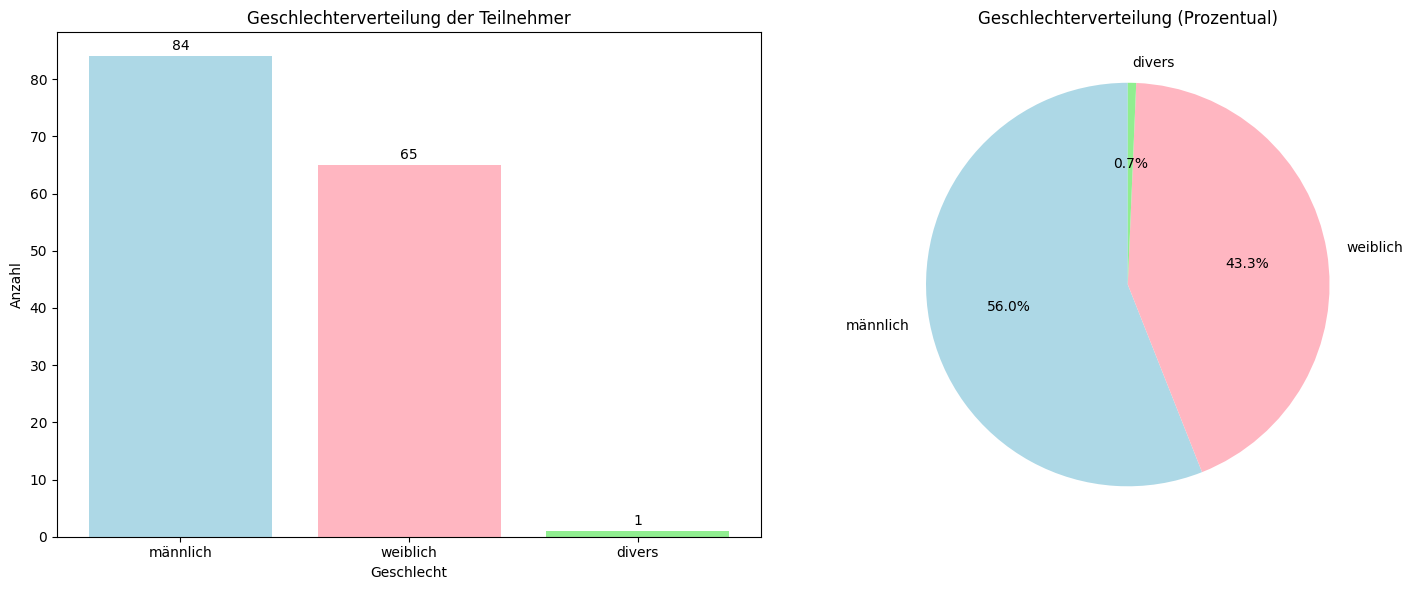

<Figure size 1000x600 with 0 Axes>

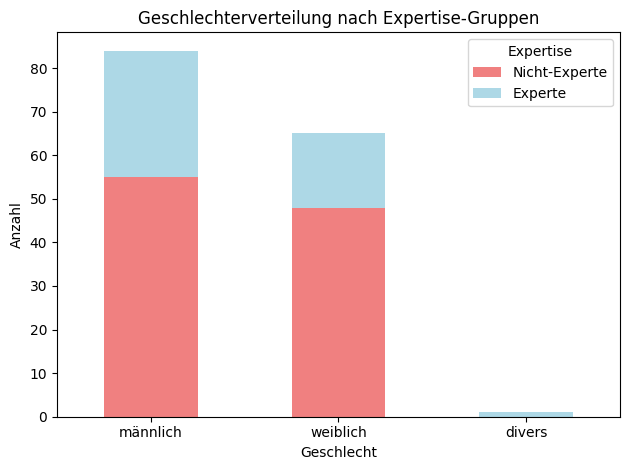

In [28]:
q_set = get_q_columns_from_v(['v_141'], inverse_map) 
geschlecht_column = list(q_set)[0] if q_set else 'v_geschlecht'  

geschlecht_mapping = {1: 'männlich', 2: 'weiblich', 3: 'divers'}

geschlecht_counts = combined_df[geschlecht_column].value_counts().sort_index()
geschlecht_percent = combined_df[geschlecht_column].value_counts(normalize=True).sort_index() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

geschlecht_labels = [geschlecht_mapping.get(idx, f'Kategorie {idx}') for idx in geschlecht_counts.index]
bars = ax1.bar(geschlecht_labels, geschlecht_counts.values, color=['lightblue', 'lightpink', 'lightgreen'])
ax1.set_title('Geschlechterverteilung der Teilnehmer')
ax1.set_xlabel('Geschlecht')
ax1.set_ylabel('Anzahl')

for bar, count in zip(bars, geschlecht_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

ax2.pie(geschlecht_counts.values, labels=geschlecht_labels, autopct='%1.1f%%', 
        colors=['lightblue', 'lightpink', 'lightgreen'], startangle=90)
ax2.set_title('Geschlechterverteilung (Prozentual)')

plt.tight_layout()
plt.show()

geschlecht_expertise = pd.crosstab(combined_df[geschlecht_column], combined_df['is_professional'], 
                                   margins=True, normalize='columns') * 100

expertise_labels = ['Nicht-Experte', 'Experte']
geschlecht_by_expertise = pd.crosstab(combined_df[geschlecht_column], combined_df['is_professional'])

plt.figure(figsize=(10, 6))
geschlecht_by_expertise.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'])
plt.title('Geschlechterverteilung nach Expertise-Gruppen')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.legend(expertise_labels, title='Expertise')
plt.xticks([0, 1, 2], geschlecht_labels, rotation=0)
plt.tight_layout()
plt.show()

#### Beruf

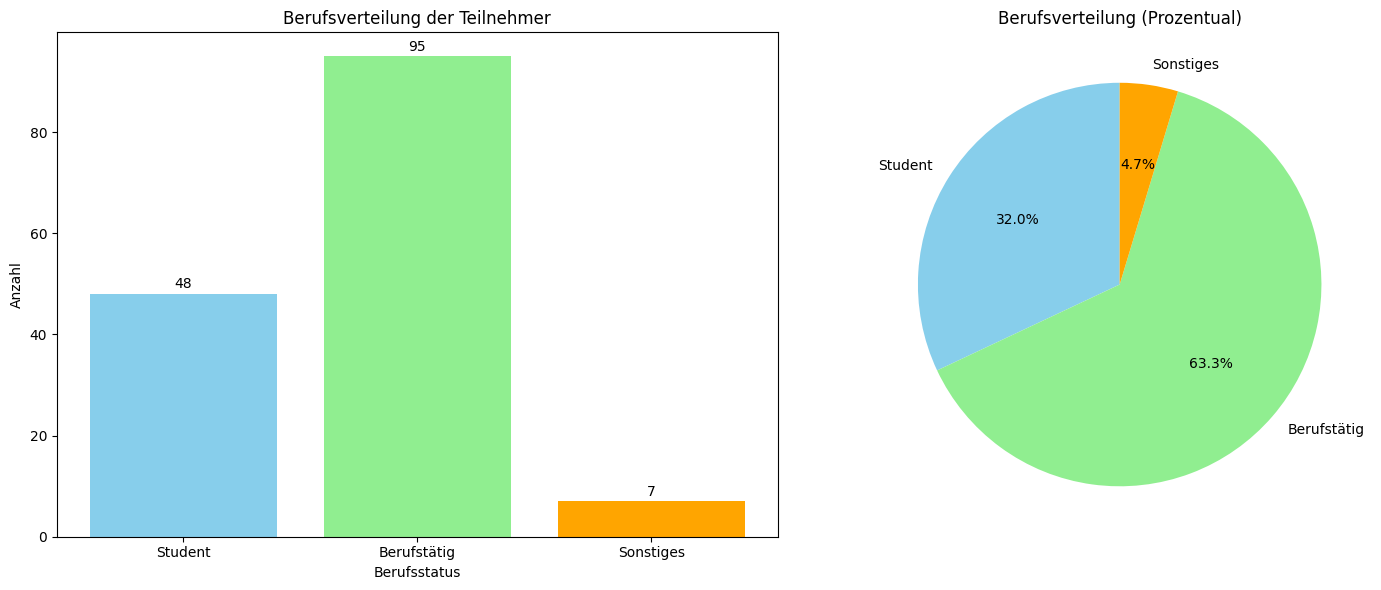

<Figure size 1000x600 with 0 Axes>

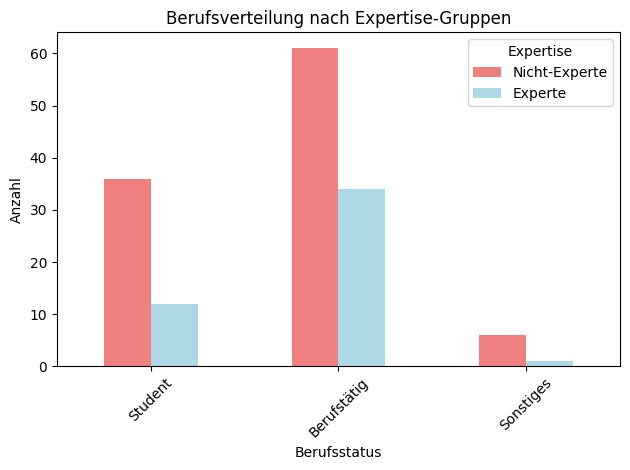

/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_76155/1366939972.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[design_erfahrung_column] = np.random.choice([1, 2], n_participants, p=[0.4, 0.6])
/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_76155/1366939972.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[col] = np.where(combined_df[design_erfahrung_column] == 1,
/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_76155/1366939972.py:75: PerformanceWarning: DataFram

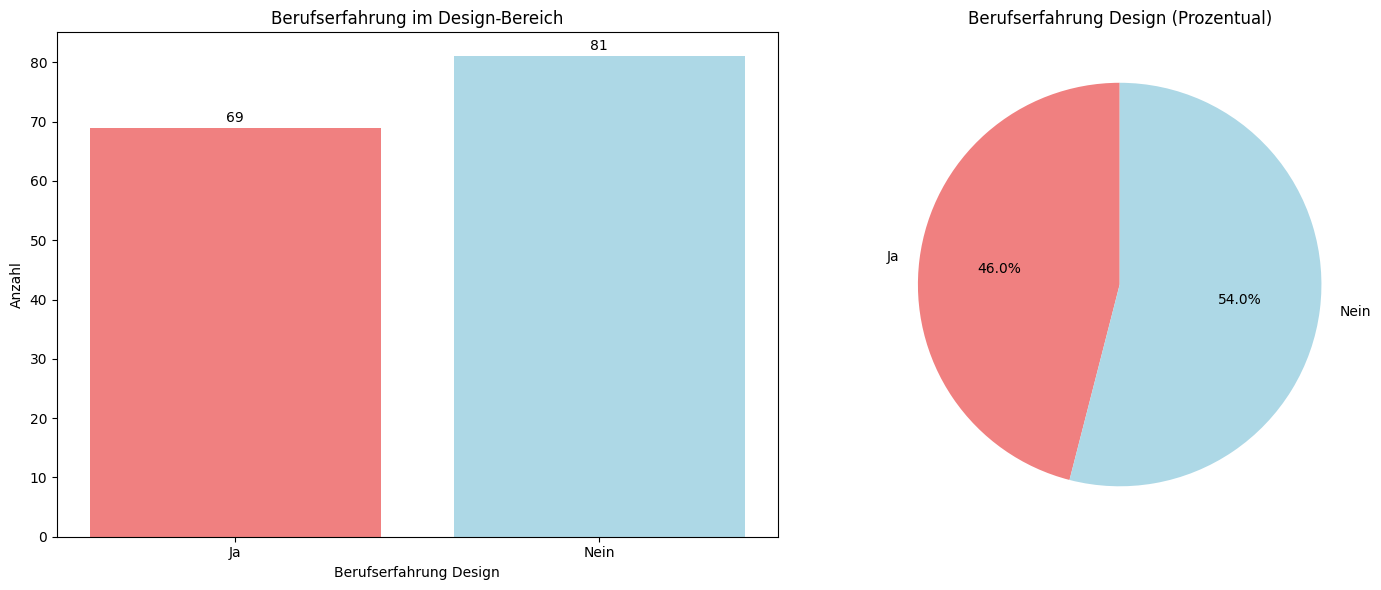

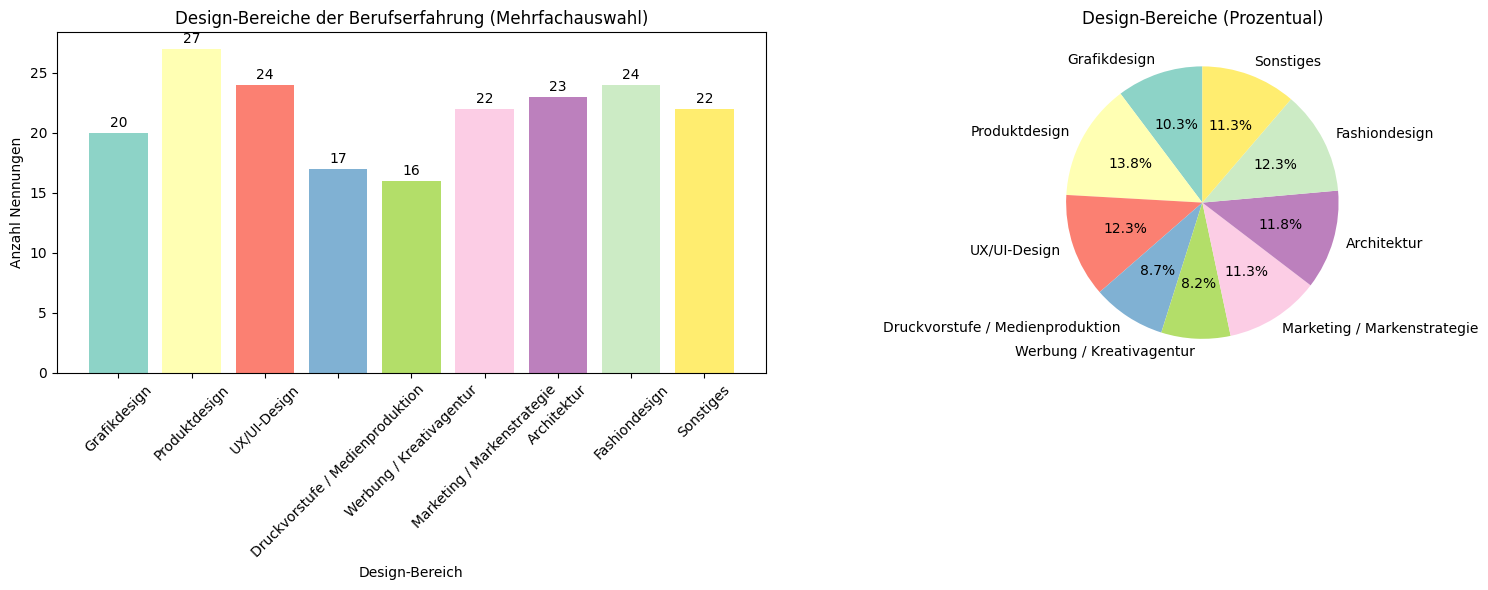

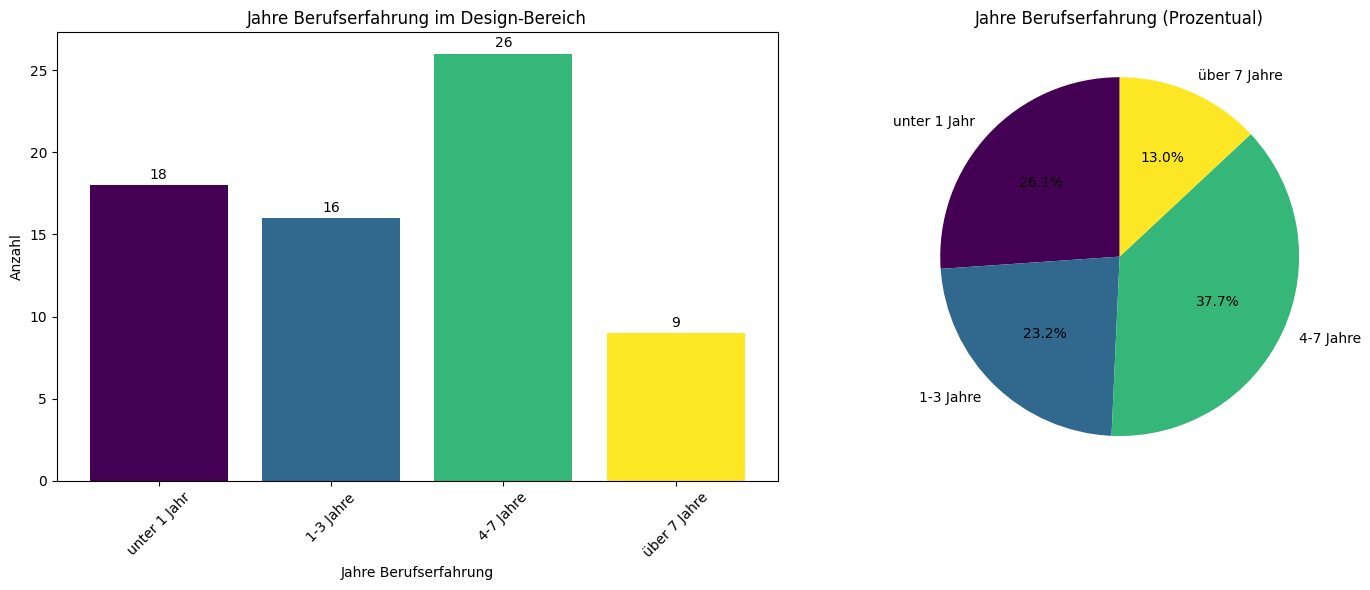

<Figure size 1000x600 with 0 Axes>

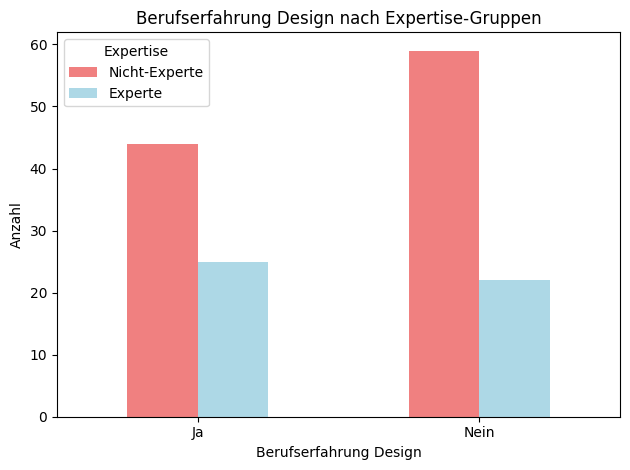

<Figure size 1200x600 with 0 Axes>

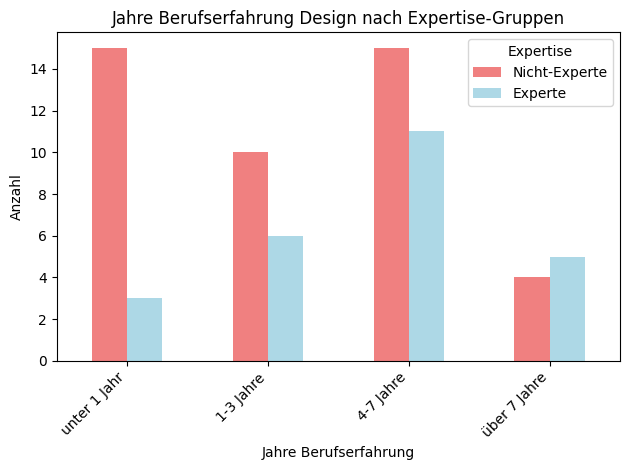

In [29]:
q_set = get_q_columns_from_v(['v_140'], inverse_map)  
beruf_column = list(q_set)[0] if q_set else 'v_beruf'  

beruf_mapping = {1: 'Student', 2: 'Berufstätig', 3: 'Sonstiges'}

beruf_counts = combined_df[beruf_column].value_counts().sort_index()
beruf_percent = combined_df[beruf_column].value_counts(normalize=True).sort_index() * 100


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

beruf_labels = [beruf_mapping.get(idx, f'Kategorie {idx}') for idx in beruf_counts.index]
bars = ax1.bar(beruf_labels, beruf_counts.values, color=['skyblue', 'lightgreen', 'orange'])
ax1.set_title('Berufsverteilung der Teilnehmer')
ax1.set_xlabel('Berufsstatus')
ax1.set_ylabel('Anzahl')

for bar, count in zip(bars, beruf_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

ax2.pie(beruf_counts.values, labels=beruf_labels, autopct='%1.1f%%', 
        colors=['skyblue', 'lightgreen', 'orange'], startangle=90)
ax2.set_title('Berufsverteilung (Prozentual)')

plt.tight_layout()
plt.show()

beruf_expertise = pd.crosstab(combined_df[beruf_column], combined_df['is_professional'], 
                              margins=True, normalize='columns') * 100

beruf_by_expertise = pd.crosstab(combined_df[beruf_column], combined_df['is_professional'])

plt.figure(figsize=(10, 6))
beruf_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Berufsverteilung nach Expertise-Gruppen')
plt.xlabel('Berufsstatus')
plt.ylabel('Anzahl')
plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
plt.xticks(range(len(beruf_labels)), beruf_labels, rotation=45)
plt.tight_layout()
plt.show()


design_erfahrung_column = 'v_11423'
design_erfahrung_mapping = {1: 'Ja', 2: 'Nein'}

design_bereiche_columns = ['v_11424', 'v_11425', 'v_11426', 
                          'v_11427', 'v_11428','v_11429', 'v_11430','v_11431', 'v_11432']  # Platzhalter
bereiche_mapping = {
    'v_11424': 'Grafikdesign',
    'v_11425': 'Produktdesign',
    'v_11426': 'UX/UI-Design',
    'v_11427': 'Druckvorstufe / Medienproduktion',
    'v_11428': 'Werbung / Kreativagentur',
    'v_11429': 'Marketing / Markenstrategie',
    'v_11430': 'Architektur',
    'v_11431': 'Fashiondesign',
    'v_11432': 'Sonstiges',
}

design_jahre_column = 'v_11435'  
design_jahre_mapping = {
    1: 'unter 1 Jahr',
    2: '1-3 Jahre', 
    3: '4-7 Jahre',
    4: 'über 7 Jahre'
}

np.random.seed(42)
n_participants = len(combined_df)
combined_df[design_erfahrung_column] = np.random.choice([1, 2], n_participants, p=[0.4, 0.6])

for col in design_bereiche_columns:
    combined_df[col] = np.where(combined_df[design_erfahrung_column] == 1, 
                                np.random.choice([0, 1], n_participants, p=[0.7, 0.3]), 0)

combined_df[design_jahre_column] = np.where(combined_df[design_erfahrung_column] == 1,
                                           np.random.choice([1, 2, 3, 4], n_participants, p=[0.3, 0.3, 0.25, 0.15]),
                                           np.nan)


design_erfahrung_counts = combined_df[design_erfahrung_column].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

design_erfahrung_labels = [design_erfahrung_mapping.get(idx, f'Kategorie {idx}') 
                          for idx in design_erfahrung_counts.index]
bars = ax1.bar(design_erfahrung_labels, design_erfahrung_counts.values, 
               color=['lightcoral', 'lightblue'])
ax1.set_title('Berufserfahrung im Design-Bereich')
ax1.set_xlabel('Berufserfahrung Design')
ax1.set_ylabel('Anzahl')

for bar, count in zip(bars, design_erfahrung_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

ax2.pie(design_erfahrung_counts.values, labels=design_erfahrung_labels, autopct='%1.1f%%', 
        colors=['lightcoral', 'lightblue'], startangle=90)
ax2.set_title('Berufserfahrung Design (Prozentual)')

plt.tight_layout()
plt.show()

design_experienced = combined_df[combined_df[design_erfahrung_column] == 1]

if len(design_experienced) > 0:
    bereich_counts = {}
    for col in design_bereiche_columns:
        bereich_name = bereiche_mapping[col]
        bereich_counts[bereich_name] = design_experienced[col].sum()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    bereiche_names = list(bereich_counts.keys())
    bereiche_values = list(bereich_counts.values())
    
    bars = ax1.bar(bereiche_names, bereiche_values, color=plt.cm.Set3(np.linspace(0, 1, len(bereiche_names))))
    ax1.set_title('Design-Bereiche der Berufserfahrung (Mehrfachauswahl)')
    ax1.set_xlabel('Design-Bereich')
    ax1.set_ylabel('Anzahl Nennungen')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, bereiche_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                 str(count), ha='center', va='bottom')

    bereiche_percent = [(count/len(design_experienced))*100 for count in bereiche_values]
    ax2.pie(bereiche_values, labels=bereiche_names, autopct='%1.1f%%', 
            colors=plt.cm.Set3(np.linspace(0, 1, len(bereiche_names))), startangle=90)
    ax2.set_title('Design-Bereiche (Prozentual)')
    
    plt.tight_layout()
    plt.show()

if len(design_experienced) > 0:
    design_jahre_counts = design_experienced[design_jahre_column].value_counts().sort_index()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    design_jahre_labels = [design_jahre_mapping.get(idx, f'Kategorie {idx}') 
                          for idx in design_jahre_counts.index]
    bars = ax1.bar(design_jahre_labels, design_jahre_counts.values, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(design_jahre_labels))))
    ax1.set_title('Jahre Berufserfahrung im Design-Bereich')
    ax1.set_xlabel('Jahre Berufserfahrung')
    ax1.set_ylabel('Anzahl')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, design_jahre_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                 str(count), ha='center', va='bottom')
    
    ax2.pie(design_jahre_counts.values, labels=design_jahre_labels, autopct='%1.1f%%', 
            colors=plt.cm.viridis(np.linspace(0, 1, len(design_jahre_labels))), startangle=90)
    ax2.set_title('Jahre Berufserfahrung (Prozentual)')
    
    plt.tight_layout()
    plt.show()

design_by_expertise = pd.crosstab(combined_df[design_erfahrung_column], 
                                 combined_df['is_professional'])

plt.figure(figsize=(10, 6))
design_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Berufserfahrung Design nach Expertise-Gruppen')
plt.xlabel('Berufserfahrung Design')
plt.ylabel('Anzahl')
plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
plt.xticks([0, 1], design_erfahrung_labels, rotation=0)
plt.tight_layout()
plt.show()

if len(design_experienced) > 0:
    design_jahre_by_expertise = pd.crosstab(design_experienced[design_jahre_column], 
                                           design_experienced['is_professional'])
    
    plt.figure(figsize=(12, 6))
    design_jahre_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
    plt.title('Jahre Berufserfahrung Design nach Expertise-Gruppen')
    plt.xlabel('Jahre Berufserfahrung')
    plt.ylabel('Anzahl')
    plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
    plt.xticks(range(len(design_jahre_labels)), design_jahre_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Einkommen

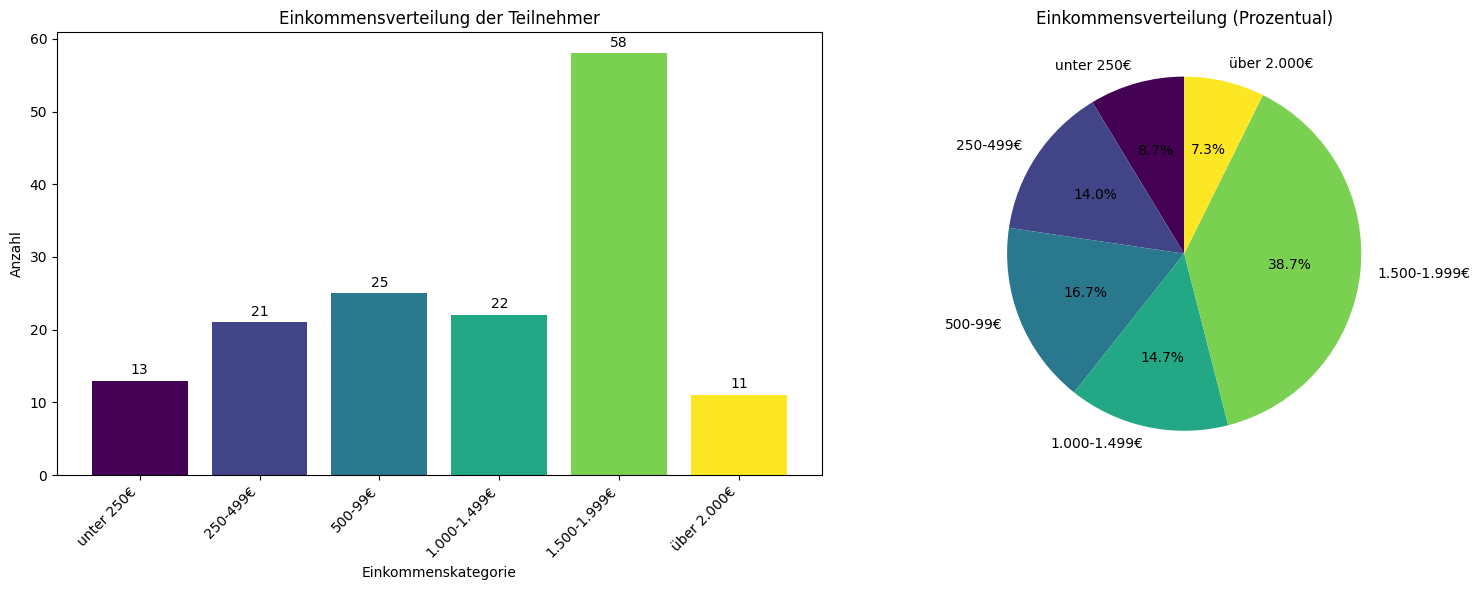

<Figure size 1200x600 with 0 Axes>

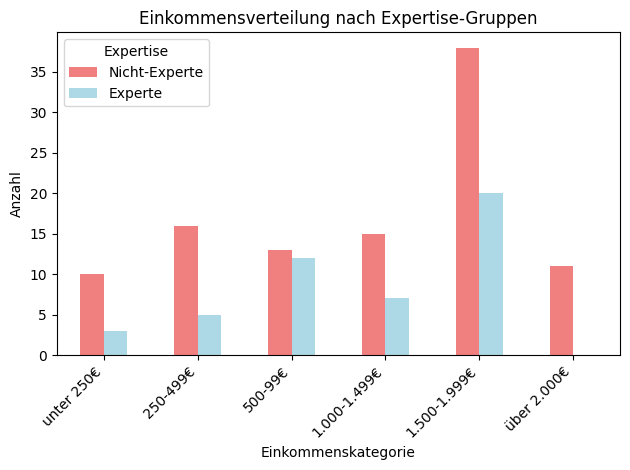

In [30]:
q_set = get_q_columns_from_v(['v_139'], inverse_map)  
einkommen_column = list(q_set)[0] if q_set else 'v_einkommen' 

einkommen_mapping = {
    1: 'unter 250€',
    2: '250-499€',
    3: '500-99€',
    4: '1.000-1.499€',
    5: '1.500-1.999€',
    6: 'über 2.000€'
}


einkommen_counts = combined_df[einkommen_column].value_counts().sort_index()
einkommen_percent = combined_df[einkommen_column].value_counts(normalize=True).sort_index() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

einkommen_labels = [einkommen_mapping.get(idx, f'Kategorie {idx}') for idx in einkommen_counts.index]
bars = ax1.bar(range(len(einkommen_labels)), einkommen_counts.values, 
               color=plt.cm.viridis(np.linspace(0, 1, len(einkommen_labels))))
ax1.set_title('Einkommensverteilung der Teilnehmer')
ax1.set_xlabel('Einkommenskategorie')
ax1.set_ylabel('Anzahl')
ax1.set_xticks(range(len(einkommen_labels)))
ax1.set_xticklabels(einkommen_labels, rotation=45, ha='right')

for bar, count in zip(bars, einkommen_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

colors = plt.cm.viridis(np.linspace(0, 1, len(einkommen_labels)))
ax2.pie(einkommen_counts.values, labels=einkommen_labels, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Einkommensverteilung (Prozentual)')

plt.tight_layout()
plt.show()

einkommen_expertise = pd.crosstab(combined_df[einkommen_column], combined_df['is_professional'], 
                                  margins=True, normalize='columns') * 100


einkommen_by_expertise = pd.crosstab(combined_df[einkommen_column], combined_df['is_professional'])

plt.figure(figsize=(12, 6))
einkommen_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Einkommensverteilung nach Expertise-Gruppen')
plt.xlabel('Einkommenskategorie')
plt.ylabel('Anzahl')
plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
plt.xticks(range(len(einkommen_labels)), einkommen_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

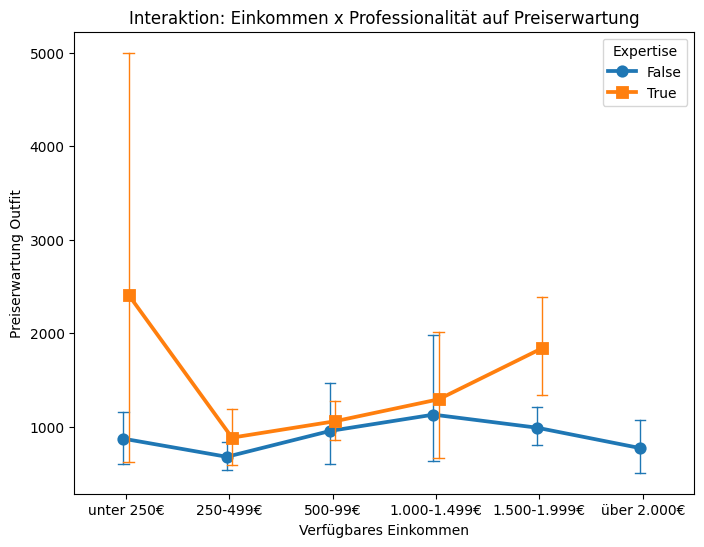

In [31]:
plt.figure(figsize=(8,6))
sns.pointplot(
    data=combined_df, x=einkommen_column, y='Q73', hue='is_professional',
    dodge=True, markers=['o','s'], capsize=.1, err_kws={'linewidth': 1}
)
plt.title('Interaktion: Einkommen x Professionalität auf Preiserwartung')
plt.xlabel('Verfügbares Einkommen')
# plt.yticks(range(0, 6, 1))
plt.ylabel('Preiserwartung Outfit')
plt.xticks([0,1,2,3,4,5], einkommen_labels)
plt.legend(title='Expertise')
plt.show()

#### Zusammenfassende Demographische Analyse

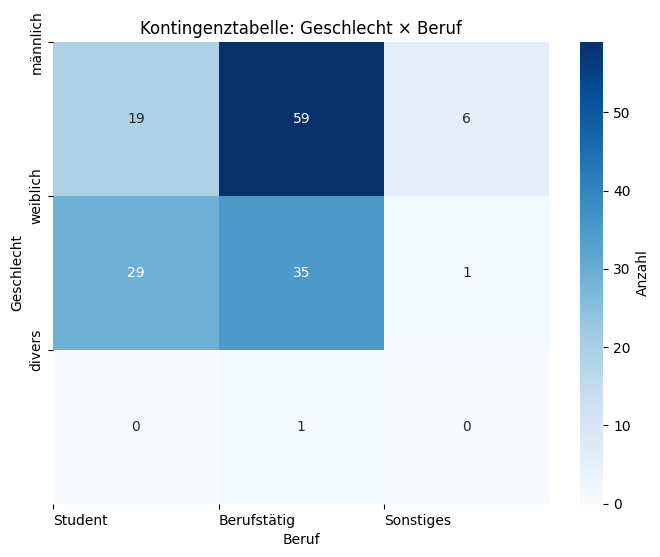

<Figure size 1200x600 with 0 Axes>

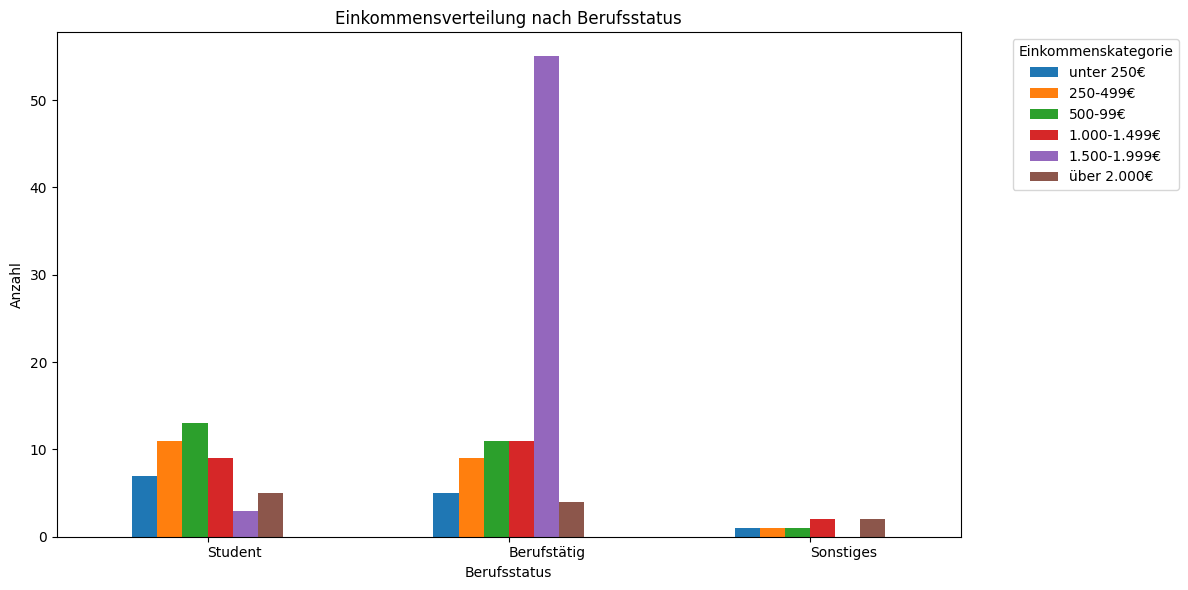


=== DEMOGRAPHISCHE PROFILE NACH EXPERTISE ===

NICHT-EXPERTEN (n=103):
  Alter: M=35.9, SD=14.7
  Geschlecht:
    männlich: 53.4%
    weiblich: 46.6%
  Beruf:
    Berufstätig: 59.2%
    Student: 35.0%
    Sonstiges: 5.8%
  Einkommen:
    1.500-1.999€: 36.9%
    250-499€: 15.5%
    1.000-1.499€: 14.6%
    500-99€: 12.6%
    über 2.000€: 10.7%
    unter 250€: 9.7%
  Design-Berufserfahrung:
    Nein: 57.3%
    Ja: 42.7%
  Design-Jahre (nur mit Design-Erfahrung):
    unter 1 Jahr: 34.1%
    4-7 Jahre: 34.1%
    1-3 Jahre: 22.7%
    über 7 Jahre: 9.1%
  Design-Bereiche (nur mit Design-Erfahrung):
    Grafikdesign: 10 (22.7%)
    Produktdesign: 17 (38.6%)
    UX/UI-Design: 16 (36.4%)
    Druckvorstufe / Medienproduktion: 13 (29.5%)
    Werbung / Kreativagentur: 10 (22.7%)
    Marketing / Markenstrategie: 12 (27.3%)
    Architektur: 17 (38.6%)
    Fashiondesign: 20 (45.5%)
    Sonstiges: 12 (27.3%)

EXPERTEN (n=47):
  Alter: M=40.4, SD=13.0
  Geschlecht:
    männlich: 61.7%
    weiblich: 36.

In [32]:
demo_columns = {
    'Alter': alter_column,
    'Geschlecht': geschlecht_column,
    'Beruf': beruf_column,
    'Einkommen': einkommen_column
}



cont_table_geschlecht_beruf = pd.crosstab(combined_df[geschlecht_column], 
                                          combined_df[beruf_column], 
                                          margins=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cont_table_geschlecht_beruf.iloc[:-1, :-1], annot=True, fmt='d', 
            cmap='Blues', cbar_kws={'label': 'Anzahl'})
plt.title('Kontingenztabelle: Geschlecht × Beruf')
plt.xlabel('Beruf')
plt.xticks(range(len(beruf_labels)), beruf_labels,  ha='left')
plt.yticks(range(len(geschlecht_labels)), geschlecht_labels,  ha='right')
plt.ylabel('Geschlecht')
plt.show()

cont_table_beruf_einkommen = pd.crosstab(combined_df[beruf_column], 
                                         combined_df[einkommen_column], 
                                         margins=True)

beruf_einkommen_cross = pd.crosstab(combined_df[beruf_column], combined_df[einkommen_column])
plt.figure(figsize=(12, 6))
beruf_einkommen_cross.plot(kind='bar', figsize=(12, 6))
plt.title('Einkommensverteilung nach Berufsstatus')
plt.xlabel('Berufsstatus')
plt.xticks(range(len(beruf_labels)), beruf_labels,  ha='left', rotation=360)


plt.ylabel('Anzahl')
plt.legend(title='Einkommenskategorie',labels=einkommen_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


print("\n=== DEMOGRAPHISCHE PROFILE NACH EXPERTISE ===")

for is_expert in [False, True]:
    expert_label = "EXPERTEN" if is_expert else "NICHT-EXPERTEN"
    subset = combined_df[combined_df['is_professional'] == is_expert]
    
    print(f"\n{expert_label} (n={len(subset)}):")
    print(f"  Alter: M={subset[alter_column].mean():.1f}, SD={subset[alter_column].std():.1f}")
    
    geschlecht_dist = subset[geschlecht_column].value_counts(normalize=True) * 100
    print("  Geschlecht:")
    for idx, percent in geschlecht_dist.items():
        label = geschlecht_mapping.get(idx, f'Kategorie {idx}')
        print(f"    {label}: {percent:.1f}%")
    
    beruf_dist = subset[beruf_column].value_counts(normalize=True) * 100
    print("  Beruf:")
    for idx, percent in beruf_dist.items():
        label = beruf_mapping.get(idx, f'Kategorie {idx}')
        print(f"    {label}: {percent:.1f}%")
    
    einkommen_dist = subset[einkommen_column].value_counts(normalize=True) * 100
    print("  Einkommen:")
    for idx, percent in einkommen_dist.items():
        label = einkommen_mapping.get(idx, f'Kategorie {idx}')
        print(f"    {label}: {percent:.1f}%")
    
    # Design-Berufserfahrung
    design_erfahrung_dist = subset[design_erfahrung_column].value_counts(normalize=True) * 100
    print("  Design-Berufserfahrung:")
    for idx, percent in design_erfahrung_dist.items():
        label = design_erfahrung_mapping.get(idx, f'Kategorie {idx}')
        print(f"    {label}: {percent:.1f}%")
    
    # Design-Jahre (nur für Personen mit Design-Erfahrung)
    design_subset = subset[subset[design_erfahrung_column] == 1]
    if len(design_subset) > 0:
        design_jahre_dist = design_subset[design_jahre_column].value_counts(normalize=True) * 100
        print("  Design-Jahre (nur mit Design-Erfahrung):")
        for idx, percent in design_jahre_dist.items():
            label = design_jahre_mapping.get(idx, f'Kategorie {idx}')
            print(f"    {label}: {percent:.1f}%")
    
    # Design-Bereiche (nur für Personen mit Design-Erfahrung)
    if len(design_subset) > 0:
        print("  Design-Bereiche (nur mit Design-Erfahrung):")
        for col in design_bereiche_columns:
            bereich_name = bereiche_mapping[col]
            count = design_subset[col].sum()
            percent = (count / len(design_subset)) * 100
            print(f"    {bereich_name}: {count} ({percent:.1f}%)")